## 🔧 Automating Casting Defect Detection with Deep Learning

Manual inspection of metal castings in manufacturing is labor-intensive, time-consuming, and costly - often requiring trained personnel to visually assess thousands of parts per day. Even with expert inspectors, human error and fatigue can lead to inconsistent results and missed defects.

This project aims to **automate the defect detection process using computer vision and deep learning**, significantly reducing operational costs while increasing speed, consistency, and accuracy. By training a convolutional neural network on labeled casting images, the model learns to distinguish between **defective** and **non-defective** parts - enabling real-time quality control with minimal human intervention.

For more information about the data utilized in this project click [here.](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

In [67]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install shap

Looking in indexes: https://download.pytorch.org/whl/cu128


In [54]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import shap
from torchvision.models import resnet18, ResNet18_Weights
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
print(torch.__version__)
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))  # Should print your GPU model

2.7.1+cu128
True
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [57]:
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(300, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [58]:
print(train_main.class_to_idx)

{'def_front': 0, 'ok_front': 1}


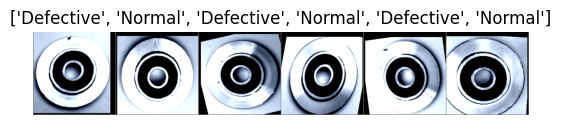

In [59]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    if title:
        plt.title(title)
    plt.axis('off')

dataiter = iter(DataLoader(train_main, batch_size=6, shuffle=True))
images, labels = next(dataiter)

mapped_titles = []
for l in labels:
    if l.item() == 1:
        mapped_titles.append('Normal')
    elif l.item() == 0:
        mapped_titles.append('Defective')
    else:
        mapped_titles.append(str(l.item()))

imshow(torchvision.utils.make_grid(images), title=mapped_titles)
plt.show()

In [60]:
train_path_main = 'data/casting_data/casting_data/train'
train_path_extra = 'data/casting_512x512/casting_512x512'
test_path = 'data/casting_data/casting_data/test'

train_main = datasets.ImageFolder(train_path_main, transform=train_transform)
train_extra = datasets.ImageFolder(train_path_extra, transform=train_transform)
test_data = datasets.ImageFolder(test_path, transform=test_transform)

combined_train = ConcatDataset([train_main, train_extra])

train_size = int(0.8 * len(combined_train))
val_size = len(combined_train) - train_size
train_data, val_data = random_split(combined_train, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, pin_memory=True)

class_names = train_main.classes
print("Classes:", class_names)

Classes: ['def_front', 'ok_front']


In [61]:
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

model = model.to(device)


In [62]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [63]:
num_epochs = 15
patience = 3
best_loss = float('inf')
counter = 0

train_metrics = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'auc': []}
val_metrics = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'auc': []}

for epoch in range(num_epochs):
    # Training
    model.train()
    y_true_train, y_pred_train, losses = [], [], []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        y_true_train += labels.cpu().numpy().flatten().tolist()
        y_pred_train += outputs.detach().cpu().numpy().flatten().tolist()

    y_pred_train_bin = [1 if p > 0.5 else 0 for p in y_pred_train]
    train_metrics['loss'].append(np.mean(losses))
    train_metrics['acc'].append(accuracy_score(y_true_train, y_pred_train_bin))
    train_metrics['prec'].append(precision_score(y_true_train, y_pred_train_bin))
    train_metrics['rec'].append(recall_score(y_true_train, y_pred_train_bin))
    train_metrics['auc'].append(roc_auc_score(y_true_train, y_pred_train))

    # Validation
    model.eval()
    y_true_val, y_pred_val, val_losses = [], [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())
            y_true_val += labels.cpu().numpy().flatten().tolist()
            y_pred_val += outputs.cpu().numpy().flatten().tolist()

    y_pred_val_bin = [1 if p > 0.5 else 0 for p in y_pred_val]
    val_loss_mean = np.mean(val_losses)
    val_metrics['loss'].append(val_loss_mean)
    val_metrics['acc'].append(accuracy_score(y_true_val, y_pred_val_bin))
    val_metrics['prec'].append(precision_score(y_true_val, y_pred_val_bin))
    val_metrics['rec'].append(recall_score(y_true_val, y_pred_val_bin))
    val_metrics['auc'].append(roc_auc_score(y_true_val, y_pred_val))

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_metrics['loss'][-1]:.4f} | "
          f"Val Loss: {val_loss_mean:.4f}")
    print(f"Val Acc: {val_metrics['acc'][-1]:.4f} | "
          f"Prec: {val_metrics['prec'][-1]:.4f} | "
          f"Rec: {val_metrics['rec'][-1]:.4f} | "
          f"AUC: {val_metrics['auc'][-1]:.4f}")

    # Early stopping
    if val_loss_mean < best_loss:
        best_loss = val_loss_mean
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/15
Train Loss: 0.0935 | Val Loss: 0.0920
Val Acc: 0.9635 | Prec: 0.9893 | Rec: 0.9267 | AUC: 0.9971
Epoch 2/15
Train Loss: 0.0373 | Val Loss: 0.0334
Val Acc: 0.9887 | Prec: 0.9761 | Rec: 0.9986 | AUC: 0.9993
Epoch 3/15
Train Loss: 0.0246 | Val Loss: 0.0128
Val Acc: 0.9956 | Prec: 0.9900 | Rec: 1.0000 | AUC: 0.9999
Epoch 4/15
Train Loss: 0.0238 | Val Loss: 0.0136
Val Acc: 0.9968 | Prec: 0.9929 | Rec: 1.0000 | AUC: 0.9998
Epoch 5/15
Train Loss: 0.0172 | Val Loss: 0.0156
Val Acc: 0.9937 | Prec: 0.9928 | Rec: 0.9928 | AUC: 0.9999
Epoch 6/15
Train Loss: 0.0127 | Val Loss: 0.0088
Val Acc: 0.9962 | Prec: 0.9915 | Rec: 1.0000 | AUC: 1.0000
Epoch 7/15
Train Loss: 0.0134 | Val Loss: 0.0120
Val Acc: 0.9956 | Prec: 0.9900 | Rec: 1.0000 | AUC: 0.9999
Epoch 8/15
Train Loss: 0.0151 | Val Loss: 0.0137
Val Acc: 0.9962 | Prec: 0.9915 | Rec: 1.0000 | AUC: 0.9999
Epoch 9/15
Train Loss: 0.0114 | Val Loss: 0.0112
Val Acc: 0.9975 | Prec: 0.9943 | Rec: 1.0000 | AUC: 0.9998
Early stopping triggered.


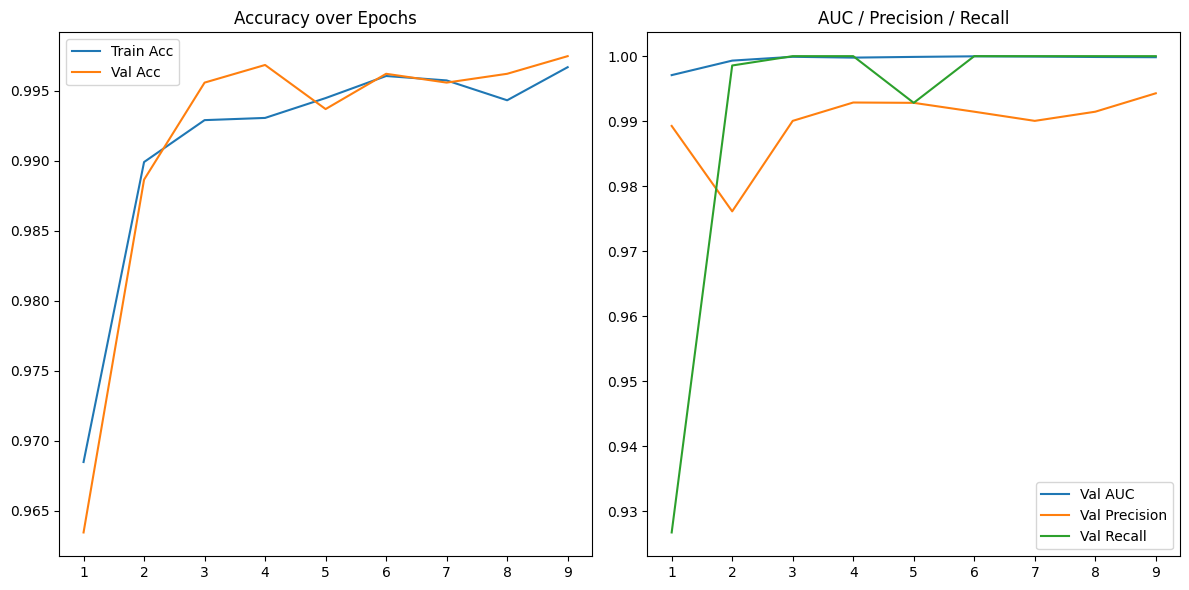

In [64]:
epochs_ran = len(train_metrics['loss'])
x = list(range(1, epochs_ran + 1))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, train_metrics['acc'], label='Train Acc')
plt.plot(x, val_metrics['acc'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, val_metrics['auc'], label='Val AUC')
plt.plot(x, val_metrics['prec'], label='Val Precision')
plt.plot(x, val_metrics['rec'], label='Val Recall')
plt.title("AUC / Precision / Recall")
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test AUC: 1.0


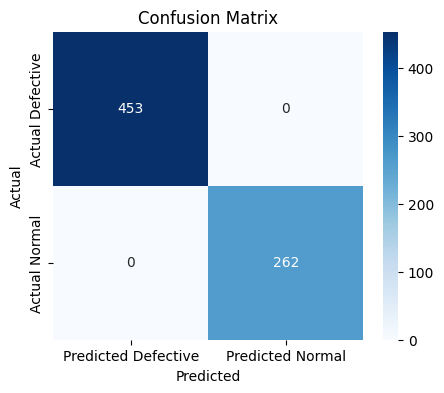

In [65]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

y_true_test, y_pred_test = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        y_true_test += labels.cpu().numpy().tolist()
        y_pred_test += outputs.cpu().numpy().flatten().tolist()

y_pred_test_bin = [1 if p > 0.5 else 0 for p in y_pred_test]

print("Test Accuracy:", accuracy_score(y_true_test, y_pred_test_bin))
print("Test Precision:", precision_score(y_true_test, y_pred_test_bin))
print("Test Recall:", recall_score(y_true_test, y_pred_test_bin))
print("Test AUC:", roc_auc_score(y_true_test, y_pred_test))


cm = confusion_matrix(y_true_test, y_pred_test_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Defective', 'Predicted Normal'],
            yticklabels=['Actual Defective', 'Actual Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Prediction Info:
Sample 0: Pred = Defective, True = Defective, Confidence = 100.00% ✓
Sample 1: Pred = Defective, True = Defective, Confidence = 100.00% ✓
Sample 2: Pred = Defective, True = Defective, Confidence = 100.00% ✓
Sample 3: Pred = Defective, True = Defective, Confidence = 100.00% ✓
Sample 4: Pred = Defective, True = Defective, Confidence = 100.00% ✓


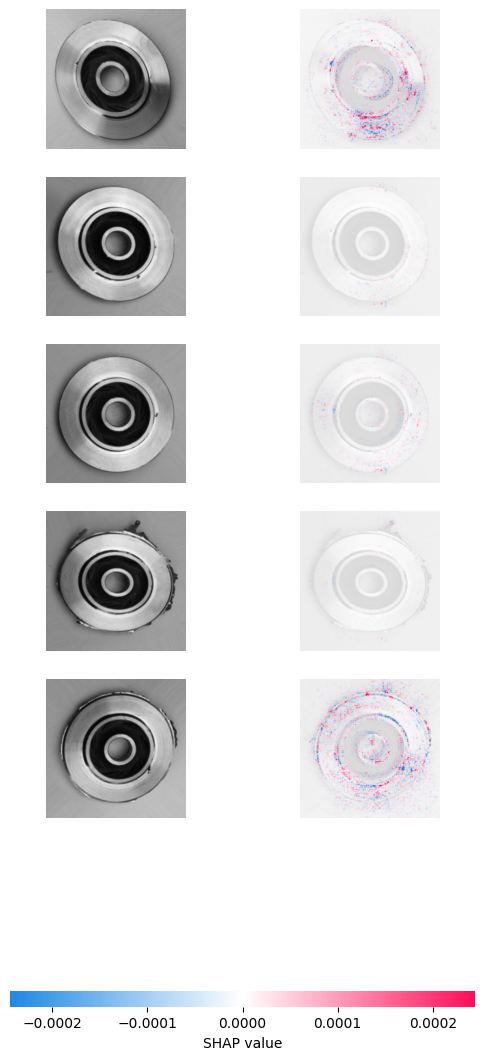

In [66]:
model.eval()

test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

random_indices = torch.randperm(test_images.size(0))[:10]
background = test_images[random_indices]

explainer = shap.GradientExplainer(model, background)

with torch.no_grad():
    outputs = model(test_images)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

incorrect_indices = (preds != test_labels).nonzero(as_tuple=True)[0].tolist()
correct_indices = (preds == test_labels).nonzero(as_tuple=True)[0].tolist()

random.shuffle(incorrect_indices)
random.shuffle(correct_indices)

num_samples = 5
selected_indices = incorrect_indices[:num_samples]
if len(selected_indices) < num_samples:
    selected_indices += correct_indices[:num_samples - len(selected_indices)]

test_samples = test_images[selected_indices]
true_labels = test_labels[selected_indices]
pred_classes = preds[selected_indices].cpu().numpy()
confidences = probs[selected_indices].max(dim=1).values.cpu().numpy()
true_classes = true_labels.cpu().numpy()

label_map = {0: 'Defective', 1: 'Normal'}

shap_values = explainer.shap_values(test_samples)

def to_channel_last(arr):
    if arr.ndim == 4:
        return np.transpose(arr, (0, 2, 3, 1))
    elif arr.ndim == 3:
        return np.transpose(arr, (1, 2, 0))
    else:
        return arr

test_samples_np = test_samples.detach().cpu().numpy()
test_samples_np = to_channel_last(test_samples_np)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
test_samples_np = (test_samples_np * std) + mean
test_samples_np = np.clip(test_samples_np, 0, 1)

if isinstance(shap_values, list):
    shap_values_np = [sv.cpu().numpy() if torch.is_tensor(sv) else sv for sv in shap_values]
    shap_values_np = np.stack(shap_values_np, axis=1)
    shap_values_np = np.transpose(shap_values_np, (1, 0, 3, 4, 5))
else:
    shap_values_np = shap_values.cpu().numpy() if torch.is_tensor(shap_values) else shap_values

print("\nPrediction Info:")
for i in range(len(pred_classes)):
    correct = pred_classes[i] == true_classes[i]
    status = "✓" if correct else "✗"
    pred_label_str = label_map.get(pred_classes[i], str(pred_classes[i]))
    true_label_str = label_map.get(true_classes[i], str(true_classes[i]))
    print(f"Sample {i}: Pred = {pred_label_str}, True = {true_label_str}, Confidence = {confidences[i]*100:.2f}% {status}")

shap_values_rgb = []

for i, class_id in enumerate(pred_classes):
    sv = shap_values_np[i, class_id]
    sv_rgb = np.repeat(sv, 3, axis=-1)
    shap_values_rgb.append(sv_rgb)

shap_values_rgb = np.stack(shap_values_rgb)

shap.image_plot(shap_values_rgb, test_samples_np)
plt.show()